In [41]:
from sklearn.datasets import fetch_openml 
import matplotlib.pyplot as plt

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)



In [42]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (70000, 784), y shape: (70000,)


In [43]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "0")[0] 
img8 = X[im8_idx].reshape(28, 28) 
plot_heatmap(img8)

In [44]:
from sklearn.model_selection import train_test_split
train_size, test_size = 1000, 1000 # Reshape to (n_samples, n_pixels_x, n_pixels_y) 
X = X.reshape((-1, 28, 28)) 
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666 ) 
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1000, 28, 28), y_train shape: (1000,)
X_test shape: (1000, 28, 28), y_test shape: (1000,)


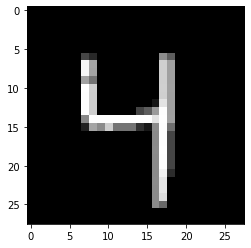

In [45]:
plt.imshow(X_test[5], cmap="gray")

Text(0.5, 1.0, 'Noisy Image with Random Noise')

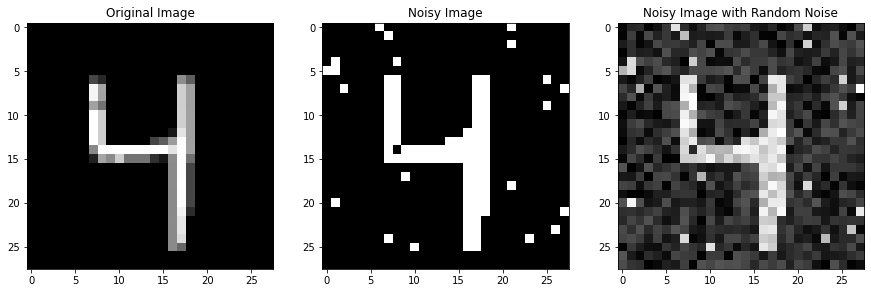

In [46]:
# distort X_train and X_test a little bit not using giotto

from skimage.util import random_noise
X_train_noisy = random_noise(X_train, mode="s&p",amount=0.05, seed=666)
X_test_noisy = random_noise(X_test, mode="s&p",amount=0.05, seed=666)

# generate random noise matrix of size X_train_noisy.shape and X_test_noisy.shape but without original image

X_train_noisy_random = np.random.rand(*X_train_noisy.shape)
X_test_noisy_random = np.random.rand(*X_test_noisy.shape)

# for each image in X_train_noisy and X_test_noisy, we will add the random noise matrix to the image

X_train_noisy_random = X_train_noisy + X_train_noisy_random
X_test_noisy_random = X_test_noisy + 0.5*X_test_noisy_random

# plot the original image, the noisy image and the noisy image with random noise

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(X_test[5], cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(X_test_noisy[5], cmap="gray")
ax[1].set_title("Noisy Image")
ax[2].imshow(X_test_noisy_random[5], cmap="gray")
ax[2].set_title("Noisy Image with Random Noise")






(1000, 28, 28)


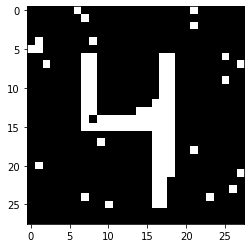

In [47]:
X_test_noisy.shape
plt.imshow(X_test_noisy[5], cmap="gray")
print(X_test_noisy.shape)

In [48]:
from gtda.images import Binarizer 

# Pick out index of first 8 image 
im8_idx = np.flatnonzero(y_train == "8")[0] # Reshape to (n_samples, n_pixels_x, n_pixels_y) format 
im8 = X_train[im8_idx][None, :, :] 
binarizer = Binarizer(threshold=0.4) 
im8_binarized = binarizer.fit_transform(im8) 
binarizer.plot(im8_binarized)


In [49]:
from gtda.images import RadialFiltration, HeightFiltration
radial_filtration = RadialFiltration(center=np.array([20,6])) 
im8_filtration = radial_filtration.fit_transform(im8_binarized) 
radial_filtration.plot(im8_filtration, colorscale="jet")


In [50]:
from gtda.homology import CubicalPersistence 
cubical_persistence = CubicalPersistence(n_jobs=-1) 
im8_cubical = cubical_persistence.fit_transform(im8_filtration) 
cubical_persistence.plot(im8_cubical)


In [51]:
from gtda.diagrams import Scaler 
scaler = Scaler() 
im8_scaled = scaler.fit_transform(im8_cubical) 
scaler.plot(im8_scaled)


In [52]:
from gtda.diagrams import HeatKernel
heat = HeatKernel(sigma=.15, n_bins=28, n_jobs=-1) 
im8_heat = heat.fit_transform(im8_scaled) # Visualise the heat kernel for H1 
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')




In [53]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

In [54]:
from gtda.diagrams import HeatKernel, PersistenceImage, BettiCurve, PersistenceLandscape, Silhouette

In [95]:
from sklearn.pipeline import make_pipeline, make_union 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Raw data processing - Scaling and normalization
raw_image_processing = Pipeline([('scaler', MinMaxScaler()), ('normalizer', StandardScaler())])

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]

"""
# Listing all metrics we want to use to extract diagram amplitudes 

metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

"""

# feature_union 
feature_union = make_union(
    PersistenceImage(sigma=.15, n_bins=28, n_jobs=-1) # or heat kernel, or possibly any other (but rational and well-fitting to model) vector representation of the diagram
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

combined_features = FeatureUnion([('tda_features', tda_union), ('raw_image_features', raw_image_processing)])

final_pipeline = Pipeline([('combine_features', combined_features)])


In [96]:
from sklearn import set_config 
set_config(display='diagram') 
final_pipeline


Pipeline(steps=[('combine_features',
                 FeatureUnion(transformer_list=[('tda_features',
                                                 FeatureUnion(n_jobs=-1,
                                                              transformer_list=[('pipeline-1',
                                                                                 Pipeline(steps=[('binarizer',
                                                                                                  Binarizer(n_jobs=-1,
                                                                                                            threshold=0.4)),
                                                                                                 ('heightfiltration',
                                                                                                  HeightFiltration(direction=array([1, 0]),
                                                                                                                   n_jobs=-1)),
                                                                                                 ('cubicalpersistence',
                                                                                                  CubicalPersistence(n_jobs=-1)),
                                                                                                 ('scaler',
                                                                                                  Scaler(n_job...
                                                                                                  RadialFiltration(center=array([20, 20]),
                                                                                                                   n_jobs=-1)),
                                                                                                 ('cubicalpersistence',
                                                                                                  CubicalPersistence(n_jobs=-1)),
                                                                                                 ('scaler',
                                                                                                  Scaler(n_jobs=-1)),
                                                                                                 ('featureunion',
                                                                                                  FeatureUnion(transformer_list=[('persistenceimage',
                                                                                                                                  PersistenceImage(n_bins=28,
                                                                                                                                                   n_jobs=-1,
                                                                                                                                                   sigma=0.15))]))]))])),
                                                ('raw_image_features',
                                                 Pipeline(steps=[('scaler',
                                                                  MinMaxScaler()),
                                                                 ('normalizer',
                                                                  StandardScaler())]))]))])

In [83]:
X_train.shape

(1000, 28, 28)

In [97]:
X_train_tda_clean = final_pipeline.fit_transform(X_train)
print(X_train_tda_clean.shape)

X_test_tda_clean = final_pipeline.transform(X_test)
print(X_test_tda_clean.shape)


ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [59]:
X_train_tda_8 = tda_union.fit_transform(X_train_noisy_random) 
X_train_tda_8.shape




(1000, 34, 28, 28)

In [60]:
X_test_tda_8 = tda_union.transform(X_test_noisy_random)
X_test_tda_8.shape

(1000, 34, 28, 28)

In [61]:
X_train_tda_good = np.transpose(X_train_tda_8, (0, 2, 3, 1))
X_test_tda_good = np.transpose(X_test_tda_8, (0, 2, 3, 1))

In [62]:
X_train_tda_clean_good = np.transpose(X_train_tda_clean, (0, 2, 3, 1))
X_test_tda_clean_good = np.transpose(X_test_tda_clean, (0, 2, 3, 1))
#shapes
print(X_train_tda_good.shape)
print(X_test_tda_good.shape)

(1000, 28, 28, 34)
(1000, 28, 28, 34)


In [63]:
X_test_tda_good.shape

(1000, 28, 28, 34)

In [64]:
import tensorflow as tf

In [65]:
tf.keras.backend.clear_session()

In [66]:

model = tf.keras.models.Sequential()
#CNN
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 34)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        9824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [69]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

model.fit(X_train_tda_clean_good, y_train, epochs=50, batch_size=1, validation_data=(X_test_tda_good, y_test), callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 1s 75ms/step - loss: 1.8675 - accuracy: 0.3970 - val_loss: 4.8578 - val_accuracy: 0.1620
Epoch 2/50
10/10 [==============================] - 1s 57ms/step - loss: 1.1182 - accuracy: 0.6870 - val_loss: 4.2283 - val_accuracy: 0.1670
Epoch 3/50
10/10 [==============================] - 1s 59ms/step - loss: 0.7754 - accuracy: 0.8040 - val_loss: 7.4644 - val_accuracy: 0.1290
Epoch 4/50
10/10 [==============================] - 1s 58ms/step - loss: 0.5742 - accuracy: 0.8440 - val_loss: 4.4950 - val_accuracy: 0.1760
Epoch 5/50
10/10 [==============================] - 1s 57ms/step - loss: 0.4502 - accuracy: 0.8770 - val_loss: 5.0158 - val_accuracy: 0.1570
Epoch 6/50
10/10 [==============================] - 1s 59ms/step - loss: 0.3472 - accuracy: 0.9080 - val_loss: 8.6805 - val_accuracy: 0.1190
Epoch 7/50
10/10 [==============================] - 1s 56ms/step - loss: 0.2884 - accuracy: 0.9230 - val_loss: 5.2372 - val_accuracy: 0.1670
Epoch 8/50
10

In [70]:
score_tda = model.evaluate(X_test_tda_good, y_test, verbose=1)

32/32 [==============================] - 0s 5ms/step - loss: 4.2283 - accuracy: 0.1670


In [71]:

# save x_test_tda and y_test
np.save('x_test_tda.npy', X_test_tda_good)
np.save('y_test.npy', y_test)


In [72]:
tf.keras.backend.clear_session()

In [73]:
# model standardowy bez tda
model2 = tf.keras.models.Sequential()
#CNN
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

In [74]:
import numpy as np
X_train_expanded = np.expand_dims(X_train, -1)
print(X_train_expanded.shape)
X_test_noisy_random_expanded = np.expand_dims(X_test_noisy_random, -1)
X_test_expanded = np.expand_dims(X_test, -1)
print(X_test_noisy_random_expanded.shape)
print(X_test_expanded.shape)

(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)


In [75]:
# fit model2
model2.fit(X_train_expanded, y_train, epochs=50, batch_size=1, validation_data=(X_test_noisy_random_expanded, y_test), callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 0s 44ms/step - loss: 18.0976 - accuracy: 0.2200 - val_loss: 2.2963 - val_accuracy: 0.1910
Epoch 2/50
10/10 [==============================] - 0s 30ms/step - loss: 2.3807 - accuracy: 0.3890 - val_loss: 2.2995 - val_accuracy: 0.2260
Epoch 3/50
10/10 [==============================] - 0s 31ms/step - loss: 1.4706 - accuracy: 0.5220 - val_loss: 2.2994 - val_accuracy: 0.1000
Epoch 4/50
10/10 [==============================] - 0s 31ms/step - loss: 0.9956 - accuracy: 0.6790 - val_loss: 2.2953 - val_accuracy: 0.1630
Epoch 5/50
10/10 [==============================] - 0s 31ms/step - loss: 0.7671 - accuracy: 0.7590 - val_loss: 2.2943 - val_accuracy: 0.1850
Epoch 6/50
10/10 [==============================] - 0s 31ms/step - loss: 0.5710 - accuracy: 0.8180 - val_loss: 2.2915 - val_accuracy: 0.2130
Epoch 7/50
10/10 [==============================] - 0s 31ms/step - loss: 0.5010 - accuracy: 0.8410 - val_loss: 2.2914 - val_accuracy: 0.2580
Epoch 8/50
1

In [76]:
score2 = model2.evaluate(X_test_noisy_random_expanded, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 2.2711 - accuracy: 0.3840


In [77]:
tf.keras.backend.clear_session()

In [78]:
# non convolutional model for standard mnist
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
                metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [79]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# fit model3
model3.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test_noisy_random, y_test), callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 0s 2ms/step - loss: 33.7922 - accuracy: 0.5950 - val_loss: 1.7902 - val_accuracy: 0.5010
Epoch 2/50
100/100 [==============================] - 0s 1ms/step - loss: 6.6579 - accuracy: 0.8560 - val_loss: 1.8075 - val_accuracy: 0.5090
Epoch 3/50
100/100 [==============================] - 0s 1ms/step - loss: 3.1931 - accuracy: 0.8990 - val_loss: 1.8333 - val_accuracy: 0.4420
Epoch 4/50
100/100 [==============================] - 0s 1ms/step - loss: 1.7443 - accuracy: 0.9350 - val_loss: 1.8319 - val_accuracy: 0.5150
Epoch 5/50
100/100 [==============================] - 0s 1ms/step - loss: 0.6398 - accuracy: 0.9630 - val_loss: 1.8400 - val_accuracy: 0.4510
Epoch 6/50
100/100 [==============================] - 0s 1ms/step - loss: 0.8209 - accuracy: 0.9650 - val_loss: 1.7989 - val_accuracy: 0.4750
Epoch 7/50
100/100 [==============================] - 0s 1ms/step - loss: 0.9723 - accuracy: 0.9680 - val_loss: 1.8019 - val_accuracy: 0.4850
Epoch

In [80]:
score3 = model3.evaluate(X_test_noisy_random, y_test)

32/32 [==============================] - 0s 781us/step - loss: 1.4407 - accuracy: 0.6440
